# 1. Getting Started

#### Get Libs

In [12]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as rq

#### Get Data

In [15]:
def download(url, file_name):
    with open(file_name, "wb") as file:
        response = rq.get(url)
        file.write(response.content)
        
# Get the data
url = 'https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/moore.csv'
download(url, 'moore.csv')

In [18]:
# Load in the data
data = pd.read_csv('moore.csv', header=None).values
X = data[:,0].reshape(-1, 1) # make it a 2-D array of size N x D where D = 1
Y = data[:,1]

# 2. Preprocessing

#### Inspect the Data

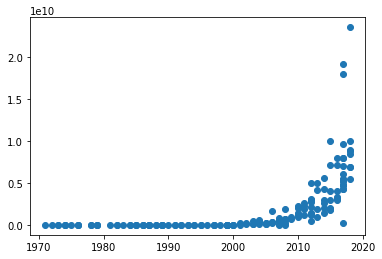

In [19]:
# Plot the data - it is exponential!
plt.scatter(X, Y)

#### Transform the Data (make it linear)

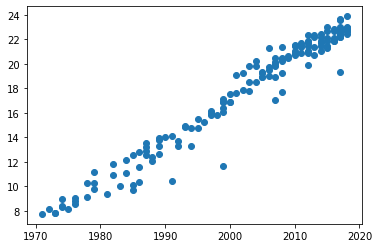

In [20]:
# Since we want a linear model, let's take the log
Y = np.log(Y)
plt.scatter(X, Y)
# that's better

#### Scale the Data

In [21]:
# Let's also center the X data so the values are not too large
# We could scale it too but then we'd have to reverse the transformation later
X = X - X.mean()

# 3. Modelling

#### Create Model

In [30]:
# Now create our Tensorflow model
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(1,)),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(0.001, 0.9), loss='mse')

#### Train the Model

In [31]:
def schedule(epoch, lr):
    if epoch >= 50:
        return 0.0001
    return 0.001
 
# Train the model
scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)
r = model.fit(X, Y, epochs=200, callbacks=[scheduler])

#### Inspect Training

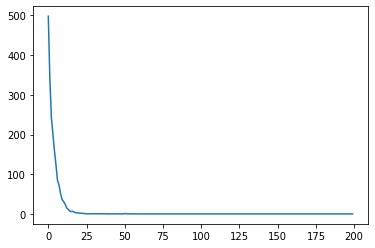

In [32]:
# Plot the loss
plt.plot(r.history['loss'], label='loss')

In [24]:
# Get the slope of the line
# The slope of the line is related to the doubling rate of transistor count
print(model.layers) # Note: there is only 1 layer, the "Input" layer doesn't count
print(model.layers[0].get_weights())

[array([[0.3439891]], dtype=float32), array([17.763088], dtype=float32)]


In [25]:
# The slope of the line is:
a = model.layers[0].get_weights()[0][0,0]

Our original model for exponential growth is:

$$ C = A_0 r^t $$

Where $ C $ is transistor the count and $ t $ is the year.

$ r $ is the rate of growth. For example, when $ t $ goes from 1 to 2, $ C $ increases by a factor of $ r $. When $ t $ goes from 2 to 3, $ C $ increases by a factor of $ r $ again.

When we take the log of both sides, we get:

$$ \log C = \log r * t + \log A_0 $$

This is our linear equation:

$$ \hat{y} = ax + b $$

Where:

$$ \hat{y} = \log C $$
$$ a = \log r $$
$$ x = t $$
$$ b = \log A_0 $$

We are interested in $ r $, because that's the rate of growth. Given our regression weights, we know that:

$$ a = 0.34188038 $$

so that:

$$ r = e^{0.34188038} = 1.4076 $$

To find the time it takes for transistor count to double, we simply need to find the amount of time it takes for $ C $ to increase to $ 2C $.

Let's call the original starting time $ t $, to correspond with the initial transistor count $ C $.

Let's call the end time $ t' $, to correspond with the final transistor count $ 2C $.

Then we also have:

$$ 2C = A_0 r ^ {t'} $$

Combine this with our original equation:

$$ C = A_0 r^t $$

We get (by dividing the 2 equations):

$$ 2C/C = (A_0 r ^ {t'}) / A_0 r^t $$

Which simplifies to:

$$ 2 = r^{(t' - t)} $$

Solve for $ t' - t $:

$$ t' - t = \frac{\log 2}{\log r} = \frac{\log2}{a}$$


Important note! We haven't specified what the starting time $ t $ actually is, and we don't have to since we just proved that this holds for any $ t $.

In [26]:
print("Time to double:", np.log(2) / a)

Time to double: 2.0150265587901406


In [27]:
# If you know the analytical solution
X = np.array(X).flatten()
Y = np.array(Y)
denominator = X.dot(X) - X.mean() * X.sum()
a = ( X.dot(Y) - Y.mean()*X.sum() ) / denominator
b = ( Y.mean() * X.dot(X) - X.mean() * X.dot(Y) ) / denominator
print(a, b)
print("Time to double:", np.log(2) / a)

0.341682487387313 17.764939393631764
Time to double: 2.0286295205239204


# Part 2: Making Predictions

This goes with the lecture "Making Predictions"

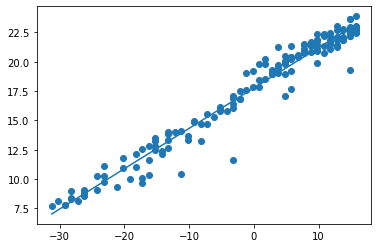

In [28]:
# Make sure the line fits our data
Yhat = model.predict(X).flatten()
plt.scatter(X, Y)
plt.plot(X, Yhat)

In [29]:
# Manual calculation

# Get the weights
w, b = model.layers[0].get_weights()

# Reshape X because we flattened it again earlier
X = X.reshape(-1, 1)

# (N x 1) x (1 x 1) + (1) --> (N x 1)
Yhat2 = (X.dot(w) + b).flatten()

# Don't use == for floating points
np.allclose(Yhat, Yhat2)

True